Preprocessing Data

In [1]:
file_path = 'Dataset.csv'
output_path = 'PreprocessedDataset.csv'

import pandas as pd
import re
import nltk 
from nltk.tokenize import word_tokenize  
from nltk.corpus import stopwords  
from nltk.stem import WordNetLemmatizer  

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
custom_stopwords = set(["rt", "amp"])

def clean_text(text):
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^A-Za-z\s]', '', text)
    return text.lower()

def preprocess_tweet(text):
    text = clean_text(text)
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words and word not in custom_stopwords]
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(tokens)

df = pd.read_csv(file_path)

df = df[df['Tweet'].apply(lambda x: isinstance(x, str))]

df['preprocessed_tweet'] = df['Tweet'].apply(preprocess_tweet)

df.to_csv(output_path, index=False)

print(df[['Party', 'Tweet', 'preprocessed_tweet']].head())

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


        Party                                              Tweet  \
0  Republican  RT @RepRyanCostello: I supported @CongressmanD...   
1  Republican  RT @HASCRepublicans: LIVE: Chairman @RepMikeTu...   
2    Democrat  During #SmallBusinessWeek, I shared some the w...   
3    Democrat  Yet another court has struck down @realDonaldT...   
4  Republican  RT @AARPOhio: More focus on Ohio's 1.5 million...   

                                  preprocessed_tweet  
0  repryancostello supported congressmandan repsi...  
1  hascrepublicans live chairman repmiketurner le...  
2  smallbusinessweek shared way san diego office ...  
3  yet another court struck realdonaldtrumps hear...  
4  aarpohio focus ohio million family caregiver t...  


Logistic Regression (LR)

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import time
from sklearn.feature_extraction.text import TfidfVectorizer

# Load your DataFrame
df = pd.read_csv('Preprocessed_finaldataset.csv')  

# Drop rows with missing labels in 'Party' and missing text in 'preprocessed_tweet', then reset index
df = df.dropna(subset=['Party', 'preprocessed_tweet']).reset_index(drop=True)

# Check the shape of the DataFrame after dropping NaN values
print(f"Number of rows in DataFrame after dropping NaNs: {len(df)}")

# Get the labels and ensure they are in the correct format
y = df['Party'].values  # Extract labels as a numpy array

# Convert the 'preprocessed_tweet' column to strings, if not already
df['preprocessed_tweet'] = df['preprocessed_tweet'].apply(lambda x: str(x))

# Initialize the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1, 2), lowercase=True)  # Set max features to 1000
X = tfidf_vectorizer.fit_transform(df['preprocessed_tweet']).toarray()  # Use the 'preprocessed_tweet' column for TF-IDF

# Check the shapes
print("Shape of X:", X.shape)
print("Number of labels (y):", len(y))

# Encode labels to numeric values
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Check the shape of the labels after encoding
print("Shape of y_encoded:", y_encoded.shape)

# Ensure that the number of samples match before splitting
if X.shape[0] != len(y_encoded):
    print("Error: Inconsistent number of samples.")
else:
    # Split data into training and testing sets (80% training, 20% testing)
    X_train, X_test, y_train, y_testlr = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

    # Initialize the Logistic Regression classifier
    logistic_classifier = LogisticRegression(max_iter=3000)

    # Start timing the training process
    start_time = time.time()

    print("Starting Logistic Regression training...")
    logistic_classifier.fit(X_train, y_train)
    print("Logistic Regression training completed.")

    # End timing
    end_time = time.time()

    # Calculate training time
    training_time = end_time - start_time
    print(f"Training time: {training_time:.2f} seconds")

    # Make predictions on the test set
    y_predlr = logistic_classifier.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_testlr, y_predlr)
    print(f"Accuracy: {accuracy * 100:.2f}%")

    # Print detailed classification report
    print(classification_report(y_testlr, y_predlr, target_names=label_encoder.classes_))
    
    # Compute and print the confusion matrix
    cm = confusion_matrix(y_testlr, y_predlr)
    print("Confusion Matrix:")
    print(cm)


Number of rows in DataFrame after dropping NaNs: 32394
Shape of X: (32394, 1000)
Number of labels (y): 32394
Shape of y_encoded: (32394,)
Starting Logistic Regression training...
Logistic Regression training completed.
Training time: 0.25 seconds
Accuracy: 82.54%
              precision    recall  f1-score   support

    Democrat       0.78      0.91      0.84      3277
  Republican       0.89      0.74      0.81      3202

    accuracy                           0.83      6479
   macro avg       0.83      0.82      0.82      6479
weighted avg       0.83      0.83      0.82      6479

Confusion Matrix:
[[2977  300]
 [ 831 2371]]


Support Vector Machine (SVM)

In [3]:

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import time
from sklearn.feature_extraction.text import TfidfVectorizer
file_path = 'Dataset.csv'
output_path = 'PreprocessedDataset.csv'
df = pd.read_csv(output_path)

# Ensure 'preprocessed_tweet' has no NaN values
df = df.dropna(subset=['preprocessed_tweet']).reset_index(drop=True)

# Convert the 'preprocessed_tweet' column to strings (if they are not already)
df['preprocessed_tweet'] = df['preprocessed_tweet'].apply(lambda x: ' '.join(x) if isinstance(x, list) else str(x))

# Initialize the TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=800, ngram_range=(1, 2), lowercase=True)

# Fit and transform the text data
X = tfidf.fit_transform(df['preprocessed_tweet']).toarray()

# Check the shape
print("Shape of X:", X.shape)

print(df['Party'].value_counts())


# Save the TF-IDF matrix
np.save('tfidf_vectors.npy', X)

# Save the feature names (terms)
feature_names = tfidf.get_feature_names_out()  # Get the list of feature names (terms)
np.save('tfidf_feature_names.npy', feature_names)

# Later, when needed, load them:
X_loaded = np.load('tfidf_vectors.npy')  # Load TF-IDF matrix

# Load feature names, allowing pickle since it's an object array
feature_names_loaded = np.load('tfidf_feature_names.npy', allow_pickle=True)

# Example: Print terms and their TF-IDF values for the first tweet
for i, value in enumerate(X_loaded[0]):
    if value != 0:
        print(f"Term: {feature_names_loaded[i]}, TF-IDF Value: {value}")

print(X_loaded.shape)
print(X_loaded[0])
print(np.count_nonzero(X_loaded[0]))


# Load your DataFrame
df = pd.read_csv(output_path)  # Load your actual dataset

# Drop rows with missing labels in 'Party' and missing text in 'preprocessed_tweet', then reset index
df = df.dropna(subset=['Party', 'preprocessed_tweet']).reset_index(drop=True)

# Check the shape of the DataFrame after dropping NaN values
print(f"Number of rows in DataFrame after dropping NaNs: {len(df)}")

# Get the labels and ensure they are in the correct format
y = df['Party'].values  # Extract labels as a numpy array

# Convert the 'preprocessed_tweet' column to strings, if not already
df['preprocessed_tweet'] = df['preprocessed_tweet'].apply(lambda x: str(x))

# Initialize the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=800, ngram_range=(1, 2), lowercase=True)  # Set max features to 1000
X = tfidf_vectorizer.fit_transform(df['preprocessed_tweet']).toarray()  # Use the 'preprocessed_tweet' column for TF-IDF

# Check the shapes
print("Shape of X:", X.shape)
print("Number of labels (y):", len(y))

# Encode labels to numeric values
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Check the shape of the labels after encoding
print("Shape of y_encoded:", y_encoded.shape)

# Ensure that the number of samples match before splitting
if X.shape[0] != len(y_encoded):
    print("Error: Inconsistent number of samples.")
else:
    # Split data into training and testing sets (80% training, 20% testing)
    X_train, X_test, y_train, y_testsvm = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

    # Initialize the SVM classifier
    svm_classifier = SVC(kernel='rbf', C=1.0, gamma='scale')

    # Start timing the training process
    start_time = time.time()

    print("Starting SVM training...")
    svm_classifier.fit(X_train, y_train)
    print("SVM training completed.")

    # End timing
    end_time = time.time()

    # Calculate training time
    training_time = end_time - start_time
    print(f"Training time: {training_time:.2f} seconds")

    # Make predictions on the test set
    y_predsvm = svm_classifier.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_testsvm, y_predsvm)
    print(f"Accuracy: {accuracy * 100:.2f}%")

    # Print detailed classification report
    print(classification_report(y_testsvm, y_predsvm, target_names=label_encoder.classes_))
    
    # Compute and print the confusion matrix
    cm = confusion_matrix(y_testsvm, y_predsvm)
    print("Confusion Matrix:")
    print(cm)


Shape of X: (44432, 800)
Party
Republican    22302
Democrat      22130
Name: count, dtype: int64
Term: act, TF-IDF Value: 0.8561992486933349
Term: amendment, TF-IDF Value: 0.5166457650430989
(44432, 800)
[0.         0.         0.         0.         0.         0.85619925
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.51664577
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0

Random Forest (RF)

In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

# Load the preprocessed dataset
df = pd.read_csv('PreprocessedDataset.csv')

# Encode labels
label_encoder = LabelEncoder()
df['Party'] = label_encoder.fit_transform(df['Party'])

# Clean data: fill or drop missing values in the 'preprocessed_tweet' column
df['preprocessed_tweet'] = df['preprocessed_tweet'].fillna('')

# Split data into features and target
X = df['preprocessed_tweet']
y = df['Party']

# Split into training and testing sets
X_train, X_test, y_train, y_testrf = train_test_split(X, y, test_size=0.2, random_state=42)

# Vectorize the text data using TF-IDF
vectorizer = TfidfVectorizer(max_features=1000)  # Adjust max_features as needed
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Initialize and train the Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_tfidf, y_train)

# Predict and evaluate
y_predrf = rf_model.predict(X_test_tfidf)
accuracy = accuracy_score(y_testrf, y_predrf)

print(f"Accuracy: {accuracy*100:.2f}%")
print("Classification Report:")
print(classification_report(y_testrf, y_predrf, labels=np.unique(y_testrf)))

# Compute and print the confusion matrix
cm = confusion_matrix(y_testrf, y_predrf)
print("Confusion Matrix:")
print(cm)


Accuracy: 96.16%
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.96      4452
           1       0.96      0.97      0.96      4437

    accuracy                           0.96      8889
   macro avg       0.96      0.96      0.96      8889
weighted avg       0.96      0.96      0.96      8889

Confusion Matrix:
[[4255  197]
 [ 144 4293]]


Comparison Work

                 LR       SVM        RF
Metric                                 
Accuracy   0.825436  0.960617  0.961638
F1-Score   0.807424  0.960488  0.961801
Recall     0.740475  0.966379  0.967546
Precision  0.887683  0.954668  0.956125


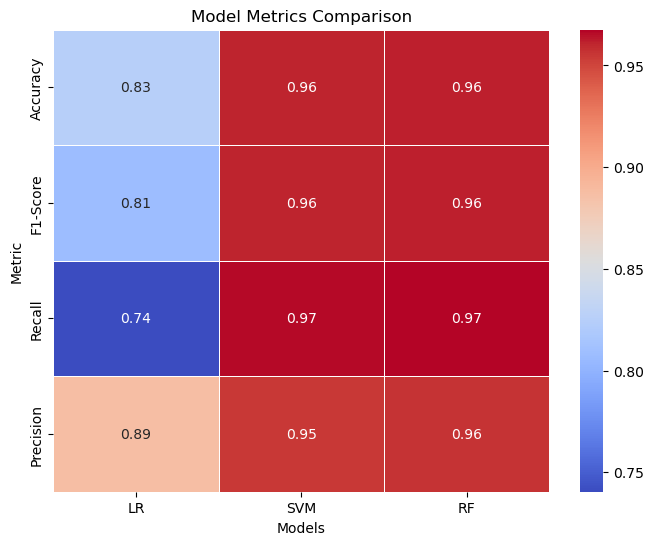

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

# Create the DataFrame for metrics
chart = {
    'Metric': ["Accuracy", "F1-Score", "Recall", "Precision"],
    'LR': [accuracy_score(y_testlr, y_predlr), f1_score(y_testlr, y_predlr), recall_score(y_testlr, y_predlr), precision_score(y_testlr, y_predlr)],
    'SVM': [accuracy_score(y_testsvm, y_predsvm), f1_score(y_testsvm, y_predsvm), recall_score(y_testsvm, y_predsvm), precision_score(y_testsvm, y_predsvm)],
    'RF': [accuracy_score(y_testrf, y_predrf), f1_score(y_testrf, y_predrf), recall_score(y_testrf, y_predrf), precision_score(y_testrf, y_predrf)]
}

# Convert to DataFrame
chart_df = pd.DataFrame(chart)

# Set Metric as index
chart_df.set_index("Metric", inplace=True)

# Check if the DataFrame contains only numeric data
print(chart_df)  # Print to verify data structure
if not chart_df.empty:
    # Plot the heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(chart_df, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5, cbar=True)
    plt.title("Model Metrics Comparison")
    plt.ylabel("Metric")
    plt.xlabel("Models")
    plt.show()
else:
    print("Error: DataFrame is empty. Please check your inputs.")
